In [ ]:
!pip install pyvi underthesea


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.4 MB/s eta 0:00:00


In [ ]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
from pyvi import ViTokenizer, ViUtils
from underthesea import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import  accuracy_score, precision_score,recall_score, f1_score,classification_report,confusion_matrix, RocCurveDisplay, roc_curve, auc,precision_recall_curve
import numpy as np

In [ ]:
# Specify the dataset folder path
dataset_folder = '/content/drive/MyDrive/NLP/dataset'

# Initialize an empty list to store data
data = []

# Iterate over all JSON files in the dataset folder
for filename in os.listdir(dataset_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(dataset_folder, filename)
        # Open and load each JSON file
        with open(file_path, 'r', encoding='utf-8') as f:
            file_data = json.load(f)
            # Extract relevant data and append to the list
            # Extract relevant fields: comments and sentiment
        for item in file_data:
            if 'comments' in item:
                for comment in item['comments']:
                    content = comment.get('content', '').strip()
                    sentiment = comment.get('sentiment', '').strip()
                    if content and sentiment:  # Keep only comments with both content and sentiment
                        data.append({
                            # 'author': comment.get('author'),
                            # 'rating': comment.get('rating'),
                            # 'time': comment.get('time'),
                            'content': content,
                            'sentiment': sentiment
                        })
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Map sentiments to readable labels
df['sentiment'] = df['sentiment'].map({'<POS>': 0, '<NEG>': 1, '<NEU>': 2})
print(df)

                                               content  sentiment
0    Chất lượng sản phẩm: tốt\nQuạt khá êm và mát, ...          0
1    Đóng gói ok cẩn thận quạt mạnh mát êm dịu khôn...          0
2    Chất lượng sản phẩm: chạy mạnh\nTính năng nổi ...          0
3    Góc review sau gần 1 tuần trải nghiệm sản phẩm...          2
4    Chất lượng sản phẩm: tốt\nTính năng nổi bật: n...          0
..                                                 ...        ...
644  Đúng với mô tả: yess\nChất lượng sản phẩm: tuy...          0
645  Chất lượng sản phẩm: Thơm ngon lắm á\nEyyy cái...          0
646  Mùi Cà phê sữa đá đã quá thơm, sau nửa tháng t...          0
647  Giao cũng lẹ. Mở ra thôi là đã thấy thơm. Đốt ...          0
648  Nến này như mùi kẹo cafe Kopiko ấy nhưng không...          2

[649 rows x 2 columns]


In [ ]:
# for i in range (len(df)):
#   if df['sentiment'][i] == 1:
#     print(i)

In [ ]:


# Load Vietnamese stopwords
def load_vietnamese_stopwords():
    with open('/content/drive/MyDrive/NLP/dataset/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()
    return set(stopwords)

vietnamese_stopwords = load_vietnamese_stopwords()

# Function to clean and preprocess text
def clean_vietnamese_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Normalize diacritics
    text = ViUtils.remove_accents(text)

    # Tokenize the text
    tokens = word_tokenize(text, format="text").split()

    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in vietnamese_stopwords]

    # Rejoin tokens into a single string
    return ' '.join(tokens)

# Apply text cleaning to the 'content' column
df['cleaned_content'] = df['content'].apply(clean_vietnamese_text)

# Display the first few rows of the cleaned data
print("Cleaned DataFrame:")
df.head()




Cleaned DataFrame:


,content,sentiment,cleaned_content
0,"Chất lượng sản phẩm: tốt\nQuạt khá êm và mát, ...",0,Chat luong san pham tot Quat_kha va_mat bat o ...
1,Đóng gói ok cẩn thận quạt mạnh mát êm dịu khôn...,0,Dong goi ok can than quat_manh mat diu khong t...
2,Chất lượng sản phẩm: chạy mạnh\nTính năng nổi ...,0,Chat luong san_pham chay_manh Tinh_nang noi ba...
3,Góc review sau gần 1 tuần trải nghiệm sản phẩm...,2,Goc review gan tuan trai nghiem san_pham cai_q...
4,Chất lượng sản phẩm: tốt\nTính năng nổi bật: n...,0,Chat luong san pham tot Tinh_nang noi bat nhu_...


In [ ]:
# Combine all cleaned content into a single string
all_text = ' '.join(df['cleaned_content'].astype(str).tolist())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(all_text)

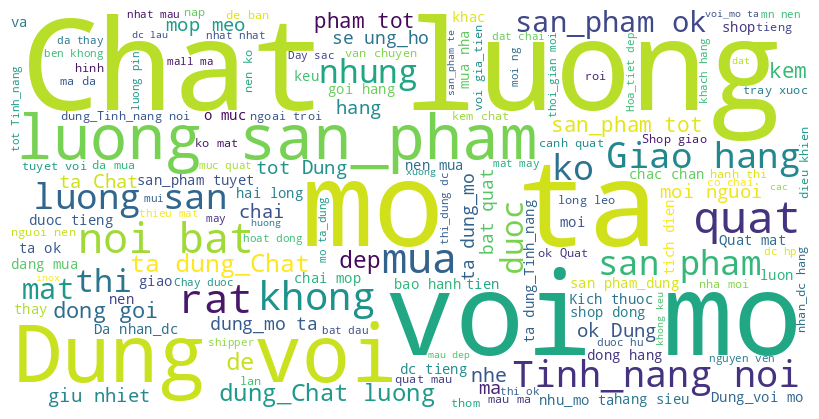

In [ ]:
# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from collections import Counter
all_tokens = []
for text in df['cleaned_content']:
     tokens = text.split()  # Split the text into tokens
     all_tokens.extend(tokens)  # Add the tokens to the overall list

token_counts = Counter(all_tokens)  # Count the frequency of each token
print(token_counts)  # Print the 10 most common tokens

Counter({'luong': 390, 'ta': 378, 'voi': 362, 'mo': 298, 'san_pham': 279, 'Chat': 277, 'Dung': 267, 'hang': 237, 'mua': 201, 'khong': 168, 'rat': 153, 'thi': 149, 'bat': 147, 'quat': 145, 'mat': 144, 'duoc': 138, 'ko': 134, 'chai': 130, 'nen': 124, 'tot': 121, 'moi': 119, 'dc': 117, 'nhung': 113, 'dep': 111, 'ok': 109, 'san': 107, 'noi': 106, 'Quat': 104, 'k': 103, 'de': 97, 'da': 96, 'thay': 93, 'ma': 92, 'shop': 85, 'on': 83, 'dong': 80, 'mau': 79, 'pham': 78, 'giao': 77, 'Tinh_nang': 74, 'day': 74, 'nhe': 71, 'chac': 71, 'luon': 71, 'chat': 71, 'Giao': 67, 'goi': 66, 'tui': 66, 'lau': 64, 'tieng': 61, 'roi': 61, 'nha': 59, 'nhua': 59, 'co': 58, 'va': 57, 'than': 57, 'nhiet': 57, 'kem': 54, 'dien': 52, 'dung': 52, 'mop': 52, 'bao': 51, 'dau': 50, 'ben': 49, 'sai': 47, 'het': 46, 'hop': 44, 'van': 44, 'giu': 44, 'mui': 43, 'o': 42, 'to': 42, 'chay': 42, 'thoi_gian': 41, 'phai': 39, 'dung_Chat': 39, 'cung': 39, 'gi': 38, 'long': 38, 'may': 38, 'vua': 37, 'yeu': 36, 'dat': 36, 'ung_ho':

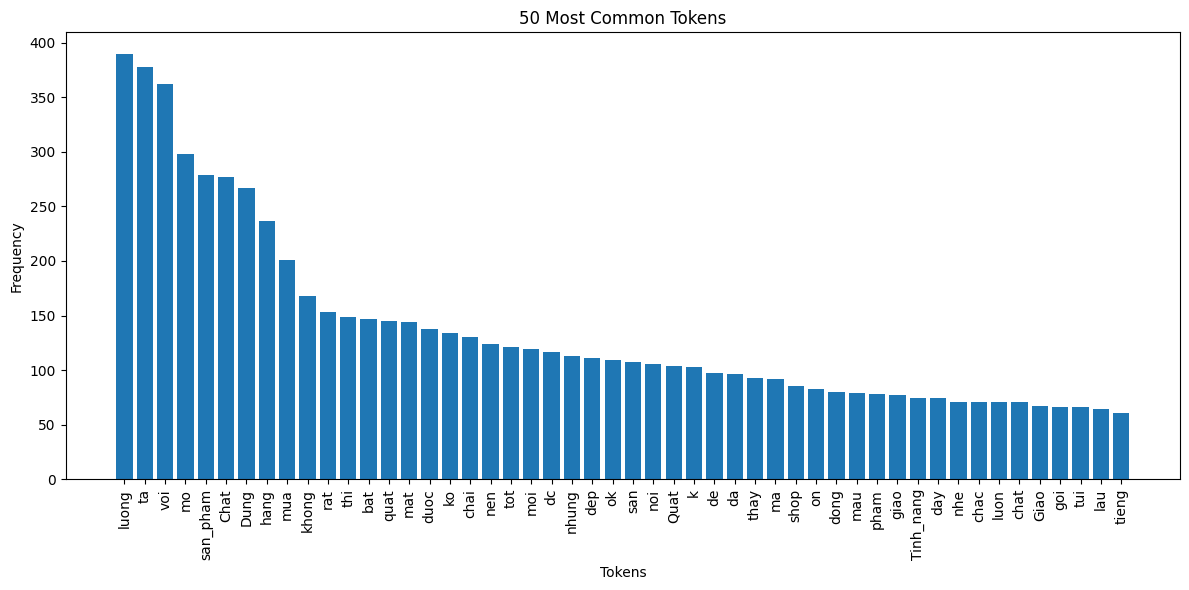

2039


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

all_tokens = []
for text in df['cleaned_content']:
    tokens = text.split()
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)

# Get the most common tokens and their frequencies
num_most_common = 50  # Change this to the desired number of most common tokens
most_common_tokens = token_counts.most_common(num_most_common)

# Extract tokens and frequencies for plotting
tokens, frequencies = zip(*most_common_tokens)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.title(f"{num_most_common} Most Common Tokens")
plt.tight_layout()
plt.show()

print(len(token_counts))  # Print the total number of unique tokens

In [ ]:
freq = np.zeros(len(token_counts))

In [ ]:
coun=np.zeros(3)
# coun_test=np.zeros(6)
for i in np.array(df['sentiment']):
  coun[i]+=1
print(coun)

[204. 305. 140.]


<BarContainer object of 3 artists>

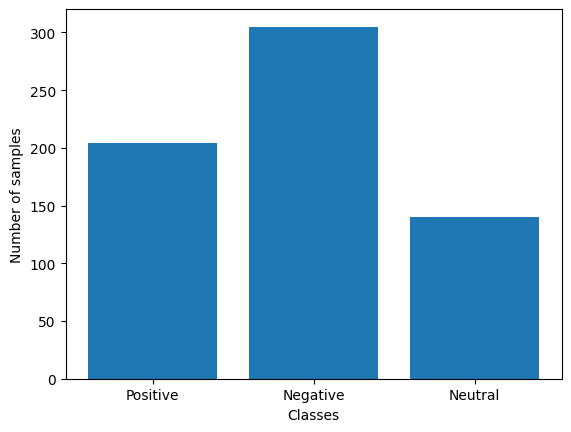

In [ ]:
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Number of samples', fontsize = 10)
classes = ["Positive","Negative", "Neutral"]
plt.bar(classes, coun)
# print(np.sum(coun))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_content'], np.array(df['sentiment']), test_size=0.2, random_state=42, stratify=df['sentiment']
)


In [ ]:
# Choose vectorizer (TF-IDF or Count)
vectorizer = TfidfVectorizer(max_features=5000)  # Use CountVectorizer() for bag-of-words
X_train_vec = vectorizer.fit_transform(X_train)
print(X_train.shape)
X_test_vec = vectorizer.transform(X_test)
print(X_test.shape)

(519,)
(130,)


In [ ]:
X_train_vec[0]

<1x1753 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [ ]:

classes = ["POG","NEG", "NEU"]
def plot_confusion_matrix(true_label, predict_label, pl = True):
    true_label = true_label.reshape(true_label.shape[0], 1)
    predict_label = predict_label.reshape(predict_label.shape[0], 1)

    cm = confusion_matrix(y_true = true_label, y_pred = predict_label)
    print(cm)
    cm_per = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100,2)

    if pl == True:
        df_cm = pd.DataFrame(cm_per, index = classes, columns = classes)
        plt.figure(figsize = (7, 6))
        sns.heatmap(df_cm, annot=True, cmap = "Blues",vmax=100, linewidths=.1 ,fmt='.2f')
        plt.title("Confusion matrix")
        plt.xlabel('Predict', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.tight_layout()


In [ ]:
# Naive Bayes Model

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

print("Naive Bayes Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))



Naive Bayes Model:
Accuracy: 0.9076923076923077
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        41
           1       0.85      1.00      0.92        61
           2       1.00      0.71      0.83        28

    accuracy                           0.91       130
   macro avg       0.94      0.87      0.90       130
weighted avg       0.92      0.91      0.91       130



In [ ]:
# wrong_pred=[]
# for i in range(y_pred.shape[0]):
#   if


Naive Bayes Model Metrics:
Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1-Score: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        41
           1       0.85      1.00      0.92        61
           2       1.00      0.71      0.83        28

    accuracy                           0.91       130
   macro avg       0.94      0.87      0.90       130
weighted avg       0.92      0.91      0.91       130

[[37  4  0]
 [ 0 61  0]
 [ 1  7 20]]


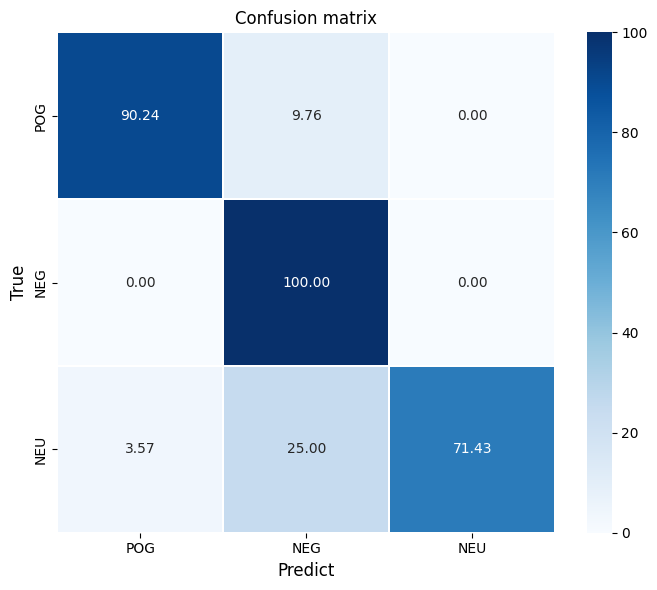

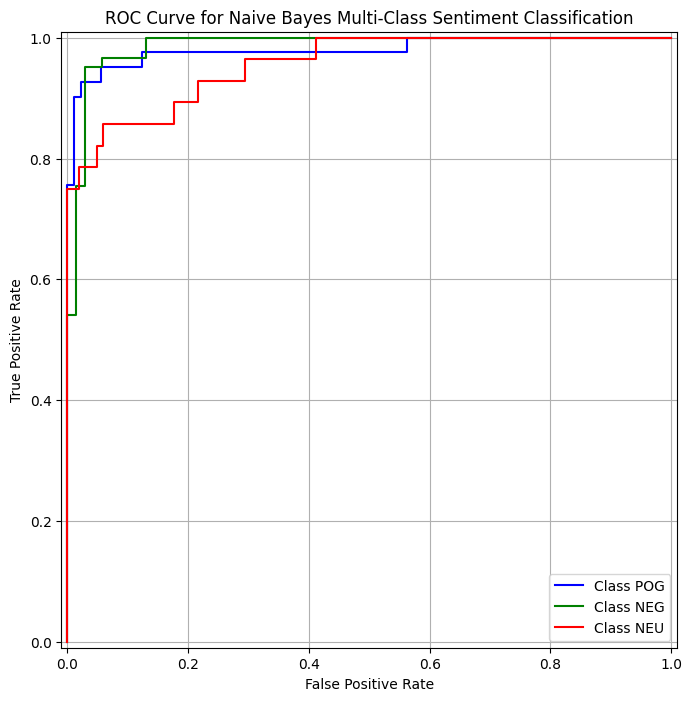

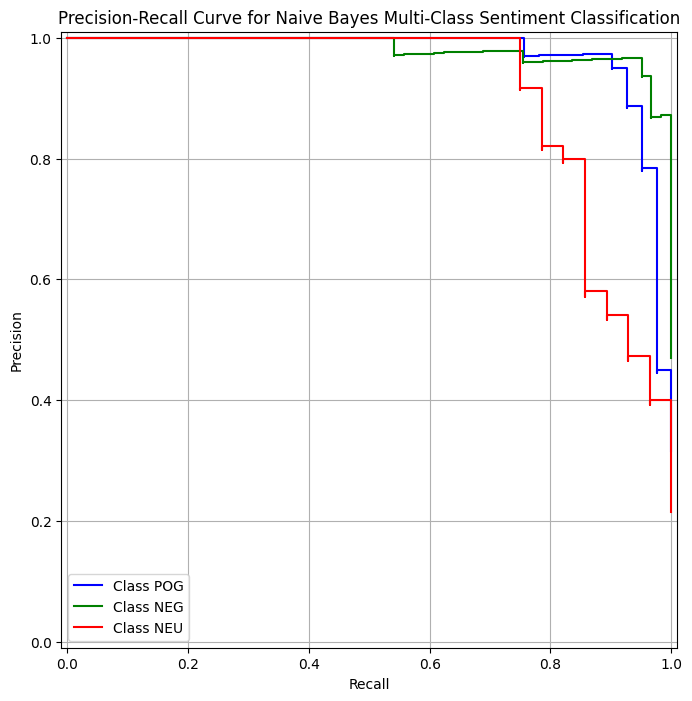

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
# from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, plot_confusion_matrix
# import matplotlib.pyplot as plt

# Calculate metrics
y_pred = nb_model.predict(X_test_vec)
model = nb_model
n_classes = 3
model_name = "Naive Bayes Model"
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n{model_name} Metrics:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)
y_score = model.predict_proba(X_test_vec)

# Calculate predicted probabilities for ROC and PR curves
y_score = model.predict_proba(X_test_vec)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Precision-Recall curve and Average Precision for each class
pr_precision = dict()
pr_recall = dict()
average_precision = dict()
for i in range(n_classes):
    pr_precision[i], pr_recall[i], _ = precision_recall_curve(y_test == i, y_score[:, i])
    average_precision[i] = average_precision_score(y_test == i, y_score[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i-1}').plot(ax=plt.gca(), color=color)

plt.title("ROC Curve for Naive Bayes Multi-Class Sentiment Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([f"Class {label}" for label in classes], loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors):
    PrecisionRecallDisplay(precision=pr_precision[i], recall=pr_recall[i], average_precision=average_precision[i]).plot(
        ax=plt.gca(), name=f'Class {i-1}', color=color
    )

plt.title("Precision-Recall Curve for Naive Bayes Multi-Class Sentiment Classification")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([f"Class {label}" for label in classes], loc="lower left")
plt.grid()
plt.show()


In [ ]:
#  Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_test_vec)

print("\nLogistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Model:
Accuracy: 0.9230769230769231
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        41
           1       0.90      1.00      0.95        61
           2       0.96      0.79      0.86        28

    accuracy                           0.92       130
   macro avg       0.93      0.90      0.91       130
weighted avg       0.93      0.92      0.92       130



In [ ]:
Text ="hang xau"
t1 =clean_vietnamese_text(Text)
t2 =vectorizer.transform([t1])
print(t2)
y_p_nb = lr_model.predict(t2)
print(y_p_nb)

  (0, 620)	0.3873243857570296
  (0, 1718)	0.9219435016300834
[1]



Logistic Regression Metrics:
Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1-Score: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        41
           1       0.90      1.00      0.95        61
           2       0.96      0.79      0.86        28

    accuracy                           0.92       130
   macro avg       0.93      0.90      0.91       130
weighted avg       0.93      0.92      0.92       130

[[37  3  1]
 [ 0 61  0]
 [ 2  4 22]]


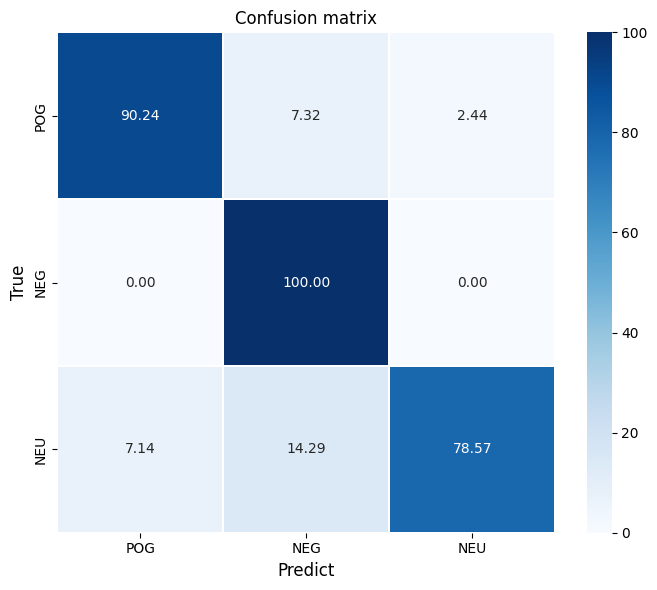

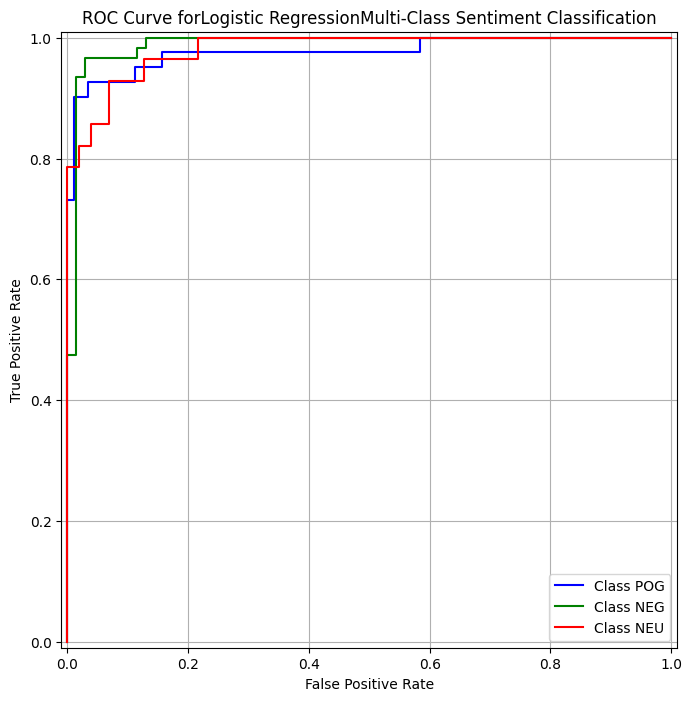

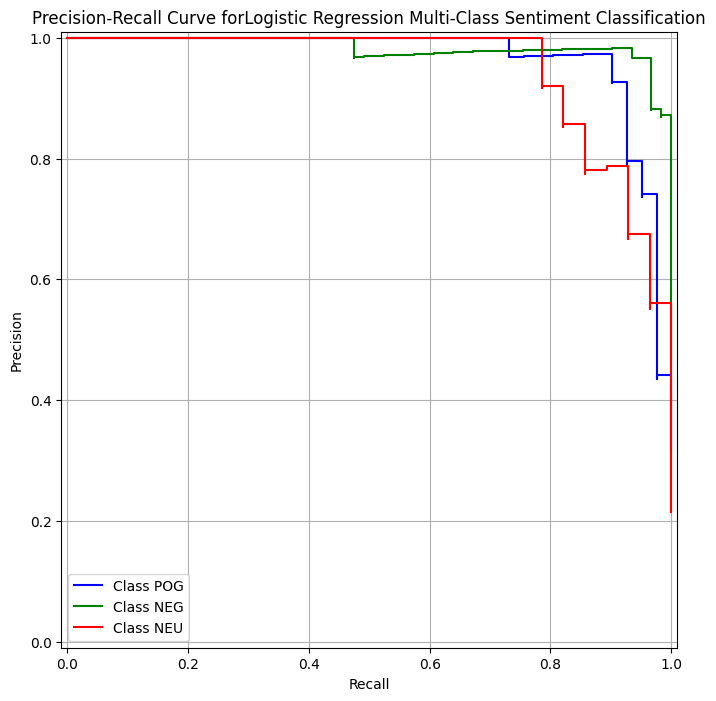

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
# from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, plot_confusion_matrix
# import matplotlib.pyplot as plt

# Calculate metrics
y_pred = lr_model.predict(X_test_vec)
model = lr_model
n_classes = 3
model_name = "Logistic Regression"
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n{model_name} Metrics:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)
y_score = model.predict_proba(X_test_vec)

# Calculate predicted probabilities for ROC and PR curves
y_score = model.predict_proba(X_test_vec)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Precision-Recall curve and Average Precision for each class
pr_precision = dict()
pr_recall = dict()
average_precision = dict()
for i in range(n_classes):
    pr_precision[i], pr_recall[i], _ = precision_recall_curve(y_test == i, y_score[:, i])
    average_precision[i] = average_precision_score(y_test == i, y_score[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i-1}').plot(ax=plt.gca(), color=color)

plt.title("ROC Curve for"+ model_name )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([f"Class {label}" for label in classes], loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors):
    PrecisionRecallDisplay(precision=pr_precision[i], recall=pr_recall[i], average_precision=average_precision[i]).plot(
        ax=plt.gca(), name=f'Class {i-1}', color=color
    )

plt.title("Precision-Recall Curve for"+ model_name +" Multi-Class Sentiment Classification")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([f"Class {label}" for label in classes], loc="lower left")
plt.grid()
plt.show()


In [ ]:
#  Logistic Regression Model
SV_model = SVC(kernel='linear', probability=True)
SV_model.fit(X_train_vec, y_train)
y_pred_SV = SV_model.predict(X_test_vec)

print("SVM Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_SV))
print("Classification Report:\n", classification_report(y_test, y_pred_SV))

SVM Model:
Accuracy: 0.9076923076923077
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        41
           1       0.89      0.97      0.93        61
           2       0.88      0.79      0.83        28

    accuracy                           0.91       130
   macro avg       0.91      0.89      0.89       130
weighted avg       0.91      0.91      0.91       130




SVM Metrics:
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-Score: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        41
           1       0.89      0.97      0.93        61
           2       0.88      0.79      0.83        28

    accuracy                           0.91       130
   macro avg       0.91      0.89      0.89       130
weighted avg       0.91      0.91      0.91       130

[[37  3  1]
 [ 0 59  2]
 [ 2  4 22]]


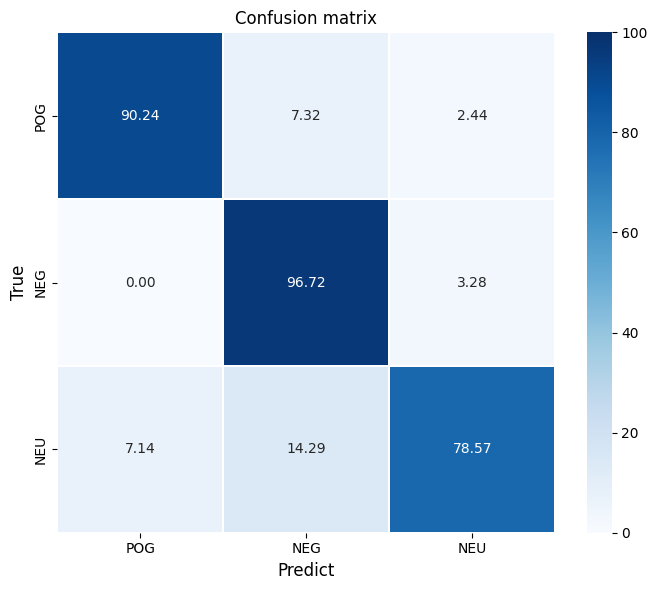

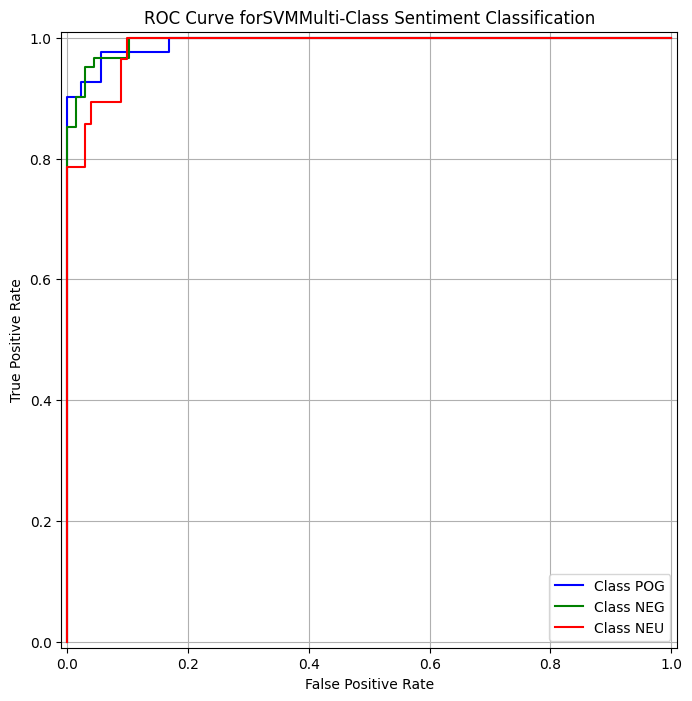

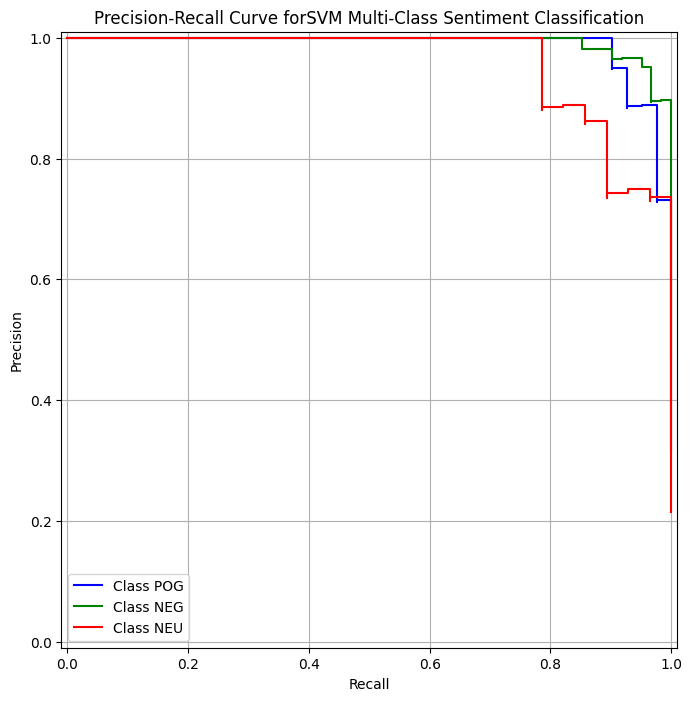

In [ ]:
# Calculate metrics
y_pred = SV_model.predict(X_test_vec)
model = SV_model
n_classes = 3
model_name = "SVM"
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n{model_name} Metrics:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)
y_score = model.predict_proba(X_test_vec)

# Calculate predicted probabilities for ROC and PR curves
y_score = model.predict_proba(X_test_vec)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Precision-Recall curve and Average Precision for each class
pr_precision = dict()
pr_recall = dict()
average_precision = dict()
for i in range(n_classes):
    pr_precision[i], pr_recall[i], _ = precision_recall_curve(y_test == i, y_score[:, i])
    average_precision[i] = average_precision_score(y_test == i, y_score[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i-1}').plot(ax=plt.gca(), color=color)

plt.title("ROC Curve for"+ model_name +"Multi-Class Sentiment Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([f"Class {label}" for label in classes], loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors):
    PrecisionRecallDisplay(precision=pr_precision[i], recall=pr_recall[i], average_precision=average_precision[i]).plot(
        ax=plt.gca(), name=f'Class {i-1}', color=color
    )

plt.title("Precision-Recall Curve for"+ model_name +" Multi-Class Sentiment Classification")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([f"Class {label}" for label in classes], loc="lower left")
plt.grid()
plt.show()


In [ ]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(X_train_vec, y_train)
y_pred_RF = RF_model.predict(X_test_vec)

print("\nLogistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_RF))
print("Classification Report:\n", classification_report(y_test, y_pred_RF))



Logistic Regression Model:
Accuracy: 0.9076923076923077
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        41
           1       0.89      0.97      0.93        61
           2       1.00      0.75      0.86        28

    accuracy                           0.91       130
   macro avg       0.93      0.88      0.90       130
weighted avg       0.91      0.91      0.91       130




Random Forest Metrics:
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-Score: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        41
           1       0.89      0.97      0.93        61
           2       1.00      0.75      0.86        28

    accuracy                           0.91       130
   macro avg       0.93      0.88      0.90       130
weighted avg       0.91      0.91      0.91       130

[[38  3  0]
 [ 2 59  0]
 [ 3  4 21]]


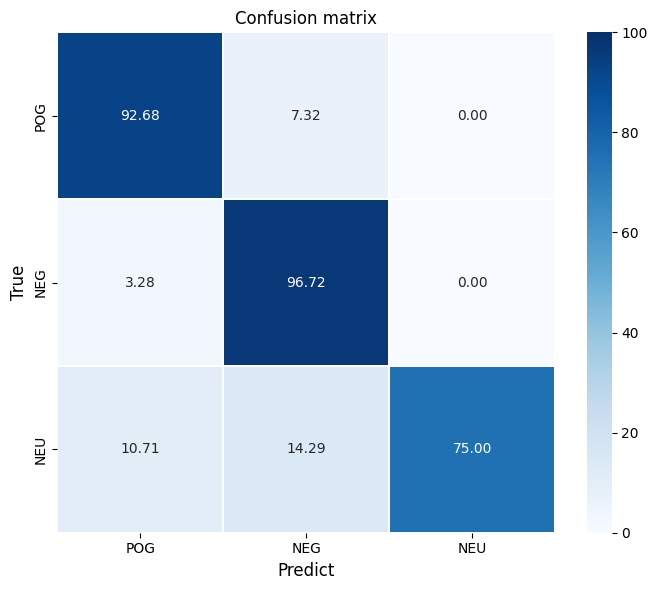

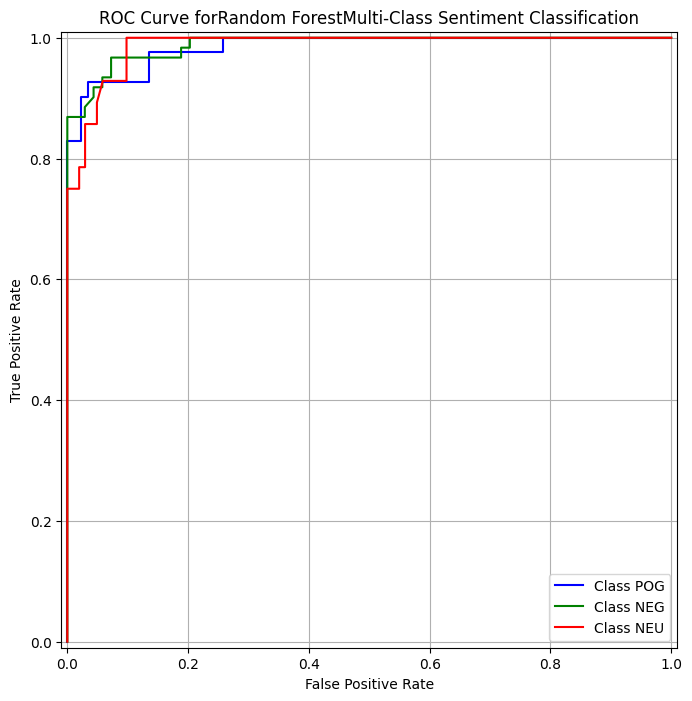

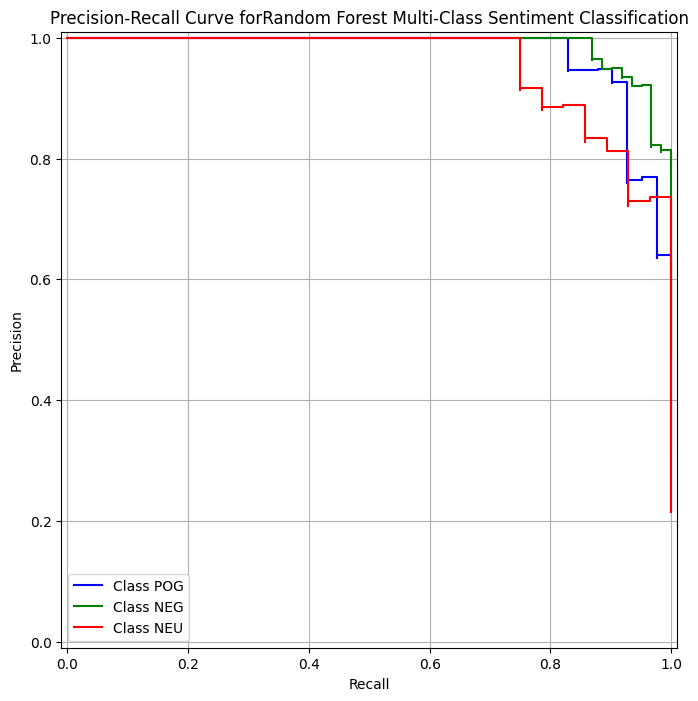

In [ ]:
# Calculate metrics
y_pred = y_pred_RF
model = RF_model
n_classes = 3
model_name = "Random Forest"
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n{model_name} Metrics:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)
y_score = model.predict_proba(X_test_vec)

# Calculate predicted probabilities for ROC and PR curves
y_score = model.predict_proba(X_test_vec)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Precision-Recall curve and Average Precision for each class
pr_precision = dict()
pr_recall = dict()
average_precision = dict()
for i in range(n_classes):
    pr_precision[i], pr_recall[i], _ = precision_recall_curve(y_test == i, y_score[:, i])
    average_precision[i] = average_precision_score(y_test == i, y_score[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i-1}').plot(ax=plt.gca(), color=color)

plt.title("ROC Curve for"+ model_name +"Multi-Class Sentiment Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([f"Class {label}" for label in classes], loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors):
    PrecisionRecallDisplay(precision=pr_precision[i], recall=pr_recall[i], average_precision=average_precision[i]).plot(
        ax=plt.gca(), name=f'Class {i-1}', color=color
    )

plt.title("Precision-Recall Curve for"+ model_name +" Multi-Class Sentiment Classification")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([f"Class {label}" for label in classes], loc="lower left")
plt.grid()
plt.show()
